                                            # 06-04-22           12:43

# MODEL 1

### Setup and Imports

Before we get started we must install sklearn and import the following modules:

In [3]:
import statsmodels

In [4]:
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.24.2


In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc     #Importing feature_column

import tensorflow as tf

Focus here is on titanic dataset. It has tons of information about each passanger on the ship. Our first step is always to understand the data and explore it.

##### The pd.read_csv() method will return to us a new pandas dataframe.
##### pop() and store 'survived' in a variable (for train and eval(test))

In [6]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') #training data-From online drive
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') #testing(lesser that training set)
y_train = dftrain.pop('survived')                 # To extract or pop a specific column
y_eval = dfeval.pop('survived')
dftrain.shape     #(We have 627 entries and 9 features)
dfeval.shape
dfeval.head()
y_eval.shape

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

##### dftrain.tail()

In [6]:
dftrain.tail()

NameError: name 'dftrain' is not defined

In [7]:
dftrain.describe()                      # A more statistical analysis of the dataset

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [8]:
y_train.head()       # represent survival in 1 & 0, i for survived and 0 for null

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

#### Visuals are always valuable let's generate a few graphs of the data:

<AxesSubplot:>

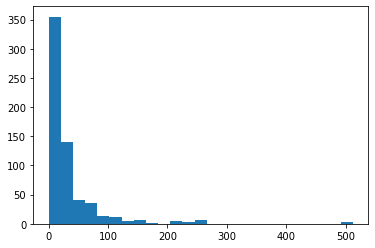

In [9]:
dftrain.fare.hist(bins=25, grid=False)

<AxesSubplot:>

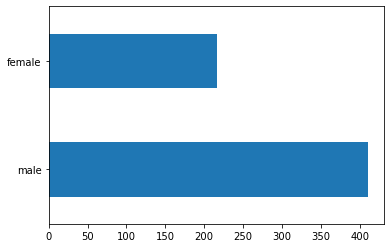

In [10]:
dftrain.sex.value_counts().plot(kind='barh', grid=False)    #('barh' for plotting sideways)

<AxesSubplot:>

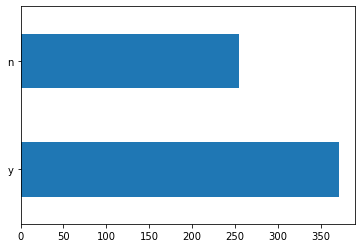

In [11]:
dftrain['alone'].value_counts().plot(kind='barh')    # Value count, to arrange according to it's set
                                                    # Use of [] for some columns

- concat; for joining two strings (y_train & dftrain)
- appending with survived
- set_xlabel('% survive') labelling of axis

Text(0.5, 0, '% survive')

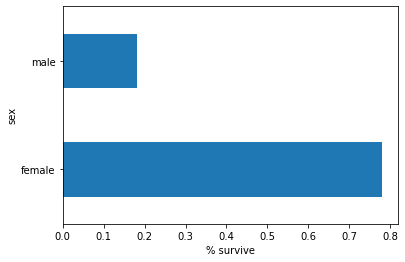

In [12]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

- Females survived the highest
- Most passengers are in their 20's or 30's
- Most passengers are male
- Most passengers are in "Third" class
- Females have a much higher chance of survival

The training data is what we feed to the model so that it can develop and learn.

The testing data is what we use to evaulate the model and see how well it is performing.

#### Feature Columns

In our dataset we have two different kinds of information; <b>Categorical and Numeric:</b>

Before we continue and create/train a model we must convert our categorical data into numeric data. We can do this by <b>encoding each category with an integer (ex. male = 1, female = 2).</b>

Fortunately TensorFlow has some tools to help!

In [13]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']     # creating a Variable for categorical datas
NUMERIC_COLUMNS = ['age', 'fare']                  #     ""        ""    for Numeric datas

feature_columns = []                            # Creating a list for feature columns
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32)) #dtype=tf.float32 -Encoding

print(feature_columns)
print(vocabulary)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

### Essentially what we are doing here is creating a list of features that are used in our dataset. The cryptic lines of code inside the append() create an object that our model can use to map string values like "male" and "female" to integers. This allows us to avoid manually having to encode our dataframes. ⤴︎

## The Training Process

- We will feed our model with simply small batches of entries, It will be fed multiple times according to the number of epochs.

- An epoch is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. 
- We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.(Ex. if we have 10 ephocs, our model will see the same dataset 10 times.)
- Since we need to feed our data in batches and multiple times, we need to create something called an input function. The input function simply defines how our dataset will be converted into batches at each epoch.

### Input Function

The TensorFlow model we are going to use requires that the data we pass it comes in as a tf.data.Dataset object. This means we must create a input function that can convert our current pandas dataframe into that object.

In [14]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

### Creating the Model

We are going to use a linear estimator to utilize the linear regression algorithm:

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/j3/csv3d2y55p5dz29j8lgrj_x80000gn/T/tmp8l4xgcs2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training the Model

Training the model is as easy as passing the *input functions* that we created earlier:

In [16]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.77272725


And we have a model with a 74% accuracy (this will change each time)!

We can use the .predict() method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set. Below we've used some pandas magic to plot a nice graph of the predictions.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/j3/csv3d2y55p5dz29j8lgrj_x80000gn/T/tmp8l4xgcs2/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

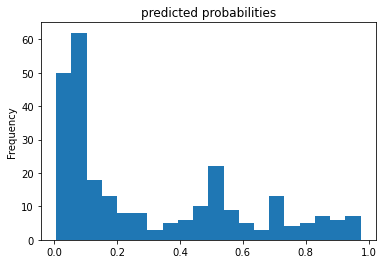

In [17]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

the survival rate is not very high ;
for linear regression! Now onto classification.

# _A_

* <b>Fundamental Machine Learning</b>
    * Linear Regression
    * Classification
    * Clustering
    * Hidden Markov Model
    

<u> Line of Bestfit:</u> A line through a scatter plot of data points that best espresses the relationship (# After training the model with data). <b>Higher probability</b> if dots are closer to the line of regression.


<b>Numpy:</b> Multi-dimensional Array

<b>Pandas:</b> Manipulate data (Analytics tool)

<b>Matplotlip:</b> Visualize charts and graphs

<u>Ipython; display.clear_output</u>

<b>TensorFlow:</b> COmpact v2 feature column(FC)

# B

* DATA: Exploring Titanic Dataset
    * Store, train and test
    * set a variable for "survived" with pop()
    * Compare both input dataset and edited dataset(trained)
    * To Look up; loc.
    * To show first 5; .head()
    * To show last 5; .tail()
    * For statistical analysis, description and overall information

#### By the Way;
* Test data is used to evaluate the training data of a model, so as to measure it's accuracy
* For all unique values from a given feature column
* Categorical data are datatype that can be stored and identified based on their given names or labels(Qualitative data)
* Numeric data is collected in number form and stands different from any form of number datatypes due to its ability to be statistically and arithmetically calculated(Qualitative data).
* Encoding of data to numbers using integer, i.e converting categorical data to numeric data
* Concatation; Joining of strings, "Concat."
* Sideways plot (barh)
* Bar Hieght (Bins)
* Epoch is the number of times the model will see the same data
* Overfitting, Optimum, Underfitting.

# C

### Training and Testing Data
Testing set is relatively lower in number compared to the training set, and is used for comparism after feeding the model.
* Creating Categorical data (str or int)
* Numerical columns (int or float)
* Implementing feature column
* Loop through categorical features
* Store data frame in new variable
* Sort out unique values .unique()
* Encoding numeric column

# D

#### What are Epochs?

Epoch is a stream of data fed to or streamed into the model in 32 batches <b>(i.e; not the entire dataset is fed at once)</b> It will be fed multiple times according to the number of Epoch <b>(training a nueral network with all the training data for one cycle)</b> made up of bacthes. 

Epoch is the amount of times the MODEL is going to see the same data;
- Making the model recognize pattern so as to make better predictions
- Working with lower ammount of <b>EPOCH or dataseft upload</b> to make it easy for the model to classify the testing data and also reduce storage.

                                         # 09-04-22           01:33

# Example; MODEL 2

## Classification
Now that we've covered linear regression it is time to talk about classification. Where regression was used to predict a numeric value, classification is used to seperate data points into classes of different labels. In this example we will use a TensorFlow estimator to classify flowers.

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import pandas as pd

# Dataset

This specific dataset seperates flowers into 3 different classes of species:
- Setosa
- Versicolor
- Virginica

The information about each flower is the following.
- sepal length
- sepal width
- petal length
- petal width

In [19]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [20]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [21]:
test.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,5.9,3.0,4.2,1.5,1
1,6.9,3.1,5.4,2.1,2
2,5.1,3.3,1.7,0.5,0
3,6.0,3.4,4.5,1.6,1
4,5.5,2.5,4.0,1.3,1


In [22]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is now gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [23]:
train.shape  # we have 120 entires with 4 features

(120, 4)

In [24]:
test.shape  # we have 30 entires with 4 features

(30, 4)

## Input Function

Remember that nasty input function we created earlier. Well we need to make another one here! Fortunatly for us this one is a little easier to digest.

In [25]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

## Feature Columns

And you didn't think we forgot about the feature columns, did you?

In [26]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)                                   # Keys are index!

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


## Building the Model

For classification tasks there are variety of different estimators/models that we can pick from. Some options are listed below.
- DNNClassifier (Deep Neural Network)
- LinearClassifier

We can choose either model but the <b>DNN</b> seems to be the best choice. This is because we may not be able to find a <u>linear coorespondence</u> in our data.

In [27]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/j3/csv3d2y55p5dz29j8lgrj_x80000gn/T/tmp71h1bp1_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<b>What we've just done is created a <u>deep neural network that has two hidden layers.</u> These layers have 30 and 10 neurons respectively. This is the number of neurons the TensorFlow official tutorial uses so we'll stick with it. However, it is worth mentioning that the number of hidden neurons is an arbitrary number and many experiments and tests are usually done to determine the best choice for these values. Try playing around with the number of hidden neurons and see if your results change.</b>

### Training

Now it's time to train the model!

In [ ]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=10000)
# We include a lambda to avoid creating an inner function previously

The only thing to explain here is the <b>steps argument</b>. This simply tells the classifier to run for <u>5000 steps</u>. Try modifiying this and seeing if your results change. Keep in mind that more is not always better.

### Evaluation

Now let's see how this trained model does!

In [29]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-09T02:46:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/j3/csv3d2y55p5dz29j8lgrj_x80000gn/T/tmp71h1bp1_/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.35069s
INFO:tensorflow:Finished evaluation at 2022-04-09-02:46:36
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.96666664, average_loss = 0.33242443, global_step = 10000, loss = 0.33242443
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /var/folders/j3/csv3d2y55p5dz29j8lgrj_x80000gn/T/tmp71h1bp1_/model.ckpt-10000

Test set accuracy: 0.967



##### Notice this time we didn't specify the number of steps. This is because during evaluation the model will only look at the testing data one time.

### Predictions

Now that we have a trained model it's time to use it to make predictions. I've written a little script below that allows you to type the features of a flower and see a prediction for its class.

In [32]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid: 
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))


Please type numeric values as prompted.
SepalLength: 23
SepalLength: 12
SepalLength: 12
SepalLength: 3
SepalLength: 4
SepalLength: 2
SepalLength: 0.5
SepalWidth: 2
SepalWidth: 0.4
PetalLength: 0.5
PetalWidth: 0.3
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/j3/csv3d2y55p5dz29j8lgrj_x80000gn/T/tmp71h1bp1_/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Versicolor" (39.2%)


In [33]:
# Here is some example input and expected classes you can try above
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

And that's pretty much it for classification!

# Clustering
Now that we've covered regression and classification it's time to talk about clustering data!
Clustering is a Machine Learning technique that involves the grouping of data points. In theory, data points that are in the same group should have similar properties and/or features, while data points in different groups should have highly dissimilar properties and/or features. (https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)
Unfortunalty there are issues with the current version of TensorFlow and the implementation for KMeans. This means we cannot use KMeans without writing the algorithm from scratch. We aren't quite at that level yet, so we'll just explain the basics of clustering for now.
Basic Algorithm for K-Means.

- Step 1: Randomly pick K points to place K centroids
- Step 2: Assign all the data points to the centroids by distance. The closest centroid to a point is the one it is assigned to.
- Step 3: Average all the points belonging to each centroid to find the middle of those clusters (center of mass). - Place the corresponding centroids into that position.
- Step 4: Reassign every point once again to the closest centroid.
- Step 5: Repeat steps 3-4 until no point changes which centroid it belongs to.

## Hidden Markov Models
"The Hidden Markov Model is a finite set of states, each of which is associated with a (generally multidimensional) probability distribution []. Transitions among the states are governed by a set of probabilities called transition probabilities." (http://jedlik.phy.bme.hu/~gerjanos/HMM/node4.html)
A hidden markov model works with probabilities to predict future events or states. In this section we will learn how to create a hidden markov model that can predict the weather.
This section is based on the following TensorFlow tutorial. https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel

## Data

- Let's start by discussing the type of data we use when we work with a hidden markov model.
- In the previous sections we worked with large datasets of 100's of different entries. For a markov model we are only interested in probability distributions that have to do with states.
- We can find these probabilities from large datasets or may already have these values. We'll run through an example in a second that should clear some things up, but let's discuss the components of a markov model.
- States: In each markov model we have a finite set of states. These states could be something like "warm" and "cold" or "high" and "low" or even "red", "green" and "blue". These states are "hidden" within the model, which means we do not direcly observe them.
- Observations: Each state has a particular outcome or observation associated with it based on a probability distribution. An example of this is the following: On a hot day Tim has a 80% chance of being happy and a 20% chance of being sad.
- Transitions: Each state will have a probability defining the likelyhood of transitioning to a different state. An example is the following: a cold day has a 30% chance of being followed by a hot day and a 70% chance of being follwed by another cold day.
- To create a hidden markov model we need.
- States
- Observation Distribution
- Transition Distribution
- For our purpose we will assume we already have this information available as we attempt to predict the weather on a given day.

# Imports and Setup
Due to a version mismatch with tensorflow v2 and tensorflow_probability we need to install the most recent version of tensorflow_probability (see below).